In [ ]:
#default_exp mplot

In [ ]:
#export 

# Periodic Table 
import mendeleev as mv 

# basic XRF physics 
from fisx import Elements 

# advanced XRF stuff that we do no need now   
#from fisx import Material
#from fisx import Detector
#from fisx import XRF 

# peak finding 
import scipy.signal as ssg
import scipy

# plotting 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import matplotlib.cm as cm 



def make_ptable(): 
    '''Make numpy array with element attributes for regular part of period table.
    
    The Lanthanides and Actinides series are very rare, so we do not plot them'''
    
    ptable_df = mv.get_table('elements')
    ptable = ptable_df[['atomic_number', 'symbol', 'name', 'group_id', 'period']].values
    is_regular = ~np.isnan(ptable_df['group_id'].values)
    
    return ptable, is_regular


def colorize(elem_selected): 
    '''Colorizes selected elements with bright high contrast colors. 
    
    Args: 
        selected_elements (list of strings): selected chemical symbols 
    Example: 
        colorize(['Ca', 'Fe']) 
    
    Returns: 
        colors (array of color tuples): 
        indices_selected (array of int): 
    '''
    
    ptable, is_regular = make_ptable()
    n_tot = len(ptable)
    n_sel = len(elem_selected)

    # initialize list with light blue grey
    default_color = [0.4, 0.4, 0.9, 0.3]  

    colors = np.ones([n_tot, 4]) 
    colors[:] = default_color
      
    # choose best bright contrast color map   
    if n_sel <= 10: 
        cmap = cm.tab10 
    elif n_sel <= 20:
        cmap = cm.tab20 
    else: 
        cmap = cm.viridis
        
    bright_colors = cmap(range(n_sel))
    
    # now update colors of selected elements 
    symbols = ptable[:,1]
    is_selected = [s in elem_selected for s in symbols]
    indices_selected = np.arange(n_tot)[is_selected] 
    
    colors[indices_selected] = bright_colors 

    return colors, indices_selected 

def draw_box(ax, element_attrs, edgecolor=None, facecolor=None):
    '''Draw a box for element *element_attrs*  in subplot *ax*. '''
    
    w = 0.9
    h = 0.9
    
    atomic_number, symbol, name, x, y = element_attrs 
    
    if edgecolor is None: 
        edgecolor = [0.8, 0.8, 1.0]
        
    if facecolor is None: 
        facecolor = [0.95, 0.95, 1.0]
    
    rect = mpatches.Rectangle([x - w/2, y - h/2], h, w, edgecolor=edgecolor, facecolor=facecolor)
    ax.add_patch(rect)
    
    ax.annotate(symbol, [x, y], xytext=[0, -4], textcoords='offset points',
                va='center', ha='center', fontsize=17)
    
    ax.annotate(atomic_number, [x, y], xytext=[0, 12], textcoords='offset points', 
                va='center', ha='center', fontsize=10)
    
    ax.annotate(name, [x, y], xytext=[0, -17], textcoords='offset points',
                va='center', ha='center', fontsize=5)
    

def ptable_plot(elem_select=None, figname=None): 
    '''Create periodic table plot with selected elements colorized.'''
    
    if elem_select is None: 
        elem_select = []
    
    # initialize full periodic table 
    ptable, is_regular = make_ptable() 
    
    # colorize full table 
    colors, _ = colorize(elem_select) 
    
    # continue with regular elements only  
    ptable = ptable[is_regular] 
    colors = colors[is_regular]
    
    # create figure 
    fig, ax = plt.subplots(figsize=[14, 8])
    ax.invert_yaxis()

    for i, element_attrs in enumerate(ptable):
        
        draw_box(ax, element_attrs, facecolor=colors[i])

    ax.set_xlim(0, 19)
    ax.set_ylim(8, 0)
    ax.axis('off');
    
    if figname is not None: 

        fig.savefig(figname) 
        


# fisx instantiation is needed before continuing 
elementsInstance = Elements()
elementsInstance.initializeAsPyMca()

class XFluo: 
    
    def __init__(self, element, tube_keV, weight_list='equal', std=0.01, min_prom=0.001): 
        '''Create an annotated x-ray fluorescence spectrum object. 
        
        Args: 
            element (str): Chemical symbol e.g 'Fe' 
            tube_keV (float or list of floats): X-ray tube energies in keV. 
               For a poly chromatic X-ray tube multiple energies can be provided.  
            weight_list (list of numbers): X-ray energy weights. 
                Corresponding to energy_list     
            std (number): Peak width used for plotting 
            min_prom (number): Minimal peak prominance. 
                Only peaks higher then prominance are labeled. 
                
        Example: 
            xf = XFluo('Fe', [20, 40])
                
        
        Returns: 
            XRF annotated spectrum object 
        '''
        # convert into list if single number
        energy_list = np.array([tube_keV]).flatten() 
        
        sorting = np.argsort(energy_list)
        energy_list = np.array(energy_list)[sorting] # need to make sure last energy is highest ? 
        
        if weight_list is 'equal': 
            weight_list = np.ones_like(energy_list) 
            
        weight_list = np.array(weight_list)[sorting]
        
        self.element = element 
        self.atomic_number = mv.element(element).atomic_number 
            
        self.x = np.linspace(0, max(energy_list), 2000) 
        
        self.total_spectrum_stack = np.zeros([len(energy_list), len(self.x)]) # initialize 

        # in order to get all lines in lines_dict need sorted energy list 
        for j, energy in enumerate(energy_list): 
        
            self.lines_dict = elementsInstance.getExcitationFactors(element, [energy]) 

            self.lines_df = pd.DataFrame(self.lines_dict).T 

            self.energies = self.lines_df['energy'].values 
            self.excitations = self.lines_df.index.values 
            self.rates = self.lines_df['rate'].values 
            #self.factors = self.lines_df['factor'].values # unclear what factor is 

            self.line_spectra = np.zeros([len(self.energies), len(self.x)]) # initialize temporary stack 

            for i, energy in enumerate(self.energies): 
                self.line_spectra[i] = self.rates[i] * np.exp(-(1 / std) * (self.x - energy)**2)

            self.total_spectrum_stack[j] = weight_list[j] * self.line_spectra.sum(axis=0) # combine gaussians  
        
        self.total_spectrum = self.total_spectrum_stack.sum(axis=0) 
        
        # normalizing heighest peak to unity 
        self.total_spectrum = self.total_spectrum / self.total_spectrum.max()
        
        peaks, props = ssg.find_peaks(self.total_spectrum, prominence=[min_prom, None])
        
        self.peak_energies = self.x[peaks]
        self.peak_intensities = self.total_spectrum[peaks] 
        
        # find indices of nearest excitations 
        nearest = np.argmin((self.lines_df['energy'][:, None] - self.peak_energies[None, :])**2, axis=0)  
        self.peak_excits = list(self.lines_df.index[nearest])
        
        
        
    def plot(self, ax=None, color=None, figsize=[12, 5], up=False, mos=False, peak_labels=True):
        '''Plot an xrf spectrum'''

        if ax is None: 
            fig, ax = plt.subplots(figsize=figsize) 
        else: 
            fig = ax.get_figure() 
            
        if up is False: 
            Z = 0 
            if mos is False: 
                h = 1 
            elif mos is True: 
                h = 4 
        else: 
            Z = self.atomic_number 
            h = 4 
            
        x = self.x 
        y = h * self.total_spectrum + Z
        
        px = self.peak_energies
        py = h * self.peak_intensities + Z 

        #ax.fill_between(self.x, self.total_spectrum, color=color, alpha=0.3)
        #ax.plot(self.x, self.total_spectrum, color=color)
        #ax.scatter(self.peak_energies, self.peak_intensities + dy, color=color) 
        
        ax.fill_between(x, y, y2=Z, color=color, alpha=0.3)
        ax.plot(x, y, color=color)
        
        if peak_labels is not 'none': 
            ax.scatter(px, py, color=color)
            for e in px: 
                ax.axvline(e, color=color, alpha=0.3)
        
        ax.set_xlabel('energy (keV)')
        #ax.set_ylim(0, 1.2)
        
        
        # peak labels 
        if peak_labels is 'full': 
            xy_list = list(zip(px, py))
            for i, s in enumerate(self.peak_excits): 
                ax.annotate(f'{self.element}\n{s}\n{self.peak_energies[i]:.2f}keV',
                            xy_list[i], 
                            xycoords='data', xytext=(0, 7), textcoords='offset points',
                            color=color, 
                            bbox=dict(boxstyle="round", alpha=0, edgecolor='white', facecolor='white')) 
                
        elif peak_labels is 'simple': 
            xy_list = list(zip(px, py))
            for i, s in enumerate(self.peak_excits): 
                ax.annotate(f'{self.element}',
                            xy_list[i], 
                            xycoords='data', xytext=(0, 7), textcoords='offset points',
                            color=color, 
                            bbox=dict(boxstyle="round", alpha=0, edgecolor='white', facecolor='white'))   
                
        elif peak_labels is 'none': 
            pass
        
        fig.tight_layout()
            
        # (self.peak_energies[i], self.peak_intensities[i]),           

def moseley_law(E_K_alpha_keV): 
    '''Square root form of Moseley's law. 
    
    Args: 
        E_K_alfa_keV (float or array of floats): K_alpha peak energy in keV 
        
    Example: 
        moseley_law(6.40)
        
    Returns: 
        Z (float or array of floats): predicted atomic number 
        
    ''' 
    Z = 1 + np.sqrt(1000 * E_K_alpha_keV / 10.2) 
    
    return Z 


def moseley_plot(tube_keV, elem_select=None, weight_list='equal', law=True, figname=None): 
    '''Generate Moseley plot of simulated xrf spectra for periodic table.
    
    Args: 
        elem_select (list of str): List of symbols of elements. 
            All selected elements will be highlighted with bright colors and peak labels. 
        tube_keV (float or list of floats): X-ray tube energy in keV. 
        weight_list (list of floats): X-ray tube intensities. 
            Optional, defaults to 'equal'. 
        
    Example: 
        moseley_plot(tube_keV=40, elem_select=['Fe', 'Ca']);
    
    Returns: 
        matplotlib figure 
            
    '''


    if elem_select is None: 
        elem_select = []

    # initialize full periodic table 
    ptable, is_regular = make_ptable() 

    # colorize full table 
    colors, indices_selected = colorize(elem_select) 

    atomic_numbers, symbols, names = ptable.T[0:3]

    fig, ax = plt.subplots(figsize=[12, 8])
    
    E_keV_list = np.linspace(0, np.max(tube_keV), 2000) 
    Z = moseley_law(E_keV_list) 
    
    ax.plot(E_keV_list, Z, zorder=-10, linestyle=':', color='k', label="Moseley's law")

    # need to limit range from 'Si' to 'Pb'
    # need to reverse the plotting order (high Z first) to get right overlap  

    Pb_Si = symbols[13:82] [::-1]
    Pb_Si_colors = colors[13:82] [::-1] 

    for s, c in list(zip(Pb_Si, Pb_Si_colors)): 
        if s in elem_select: 
            peak_labels = 'simple' 

            # ideal spectrum 
            XFluo(s, tube_keV, weight_list=weight_list).plot(ax=ax, color=c, up=False, mos=True, 
                                                             peak_labels=peak_labels)

        else: 
            peak_labels = 'none'

        XFluo(s, tube_keV, weight_list=weight_list).plot(ax=ax, color=c, up=True, peak_labels=peak_labels)

    #ax.set_yticks(atomic_numbers)
    #ax.set_yticklabels(tick_labels)

    ax.set_ylabel('Atomic number')
    ax.set_xticks(range(int(tube_keV)))
    ax.set_xlim(0, np.max(tube_keV))
    ax.set_ylim(0, 90)
    ax.grid(False) 
    ax.set_title(f'Moseley plot (x-ray tube at {np.max(tube_keV)} keV)')
    ax.legend()
    
    if figname is not None: 
        print(f'Saving plot as: {figname}...')
        fig.savefig(figname)
        
    return fig



# Moseley's law 

## From peak energies to the Periodic Table

An x-ray fluorescence spectrum for a specific pure element contains a characteristic combination of peaks of different heights at different energies. It follows that for a material that contains a mixture of different elements a  spectrum with a complex pattern of peaks will arise. Inferring a material composition from a measured XRF spectrum amounts to attributing peaks to elements. 

In 1913-1914 the young British physicist [Henry Moseley](https://en.wikipedia.org/wiki/Moseley%27s_law) discovered a beautifully simple regular pattern that relates the energy of the (typically) strongest peak in a pure element spectrum (called the $K_{\alpha}$ line) to the atomic number ($Z$). 

$$ E_{K_{\alpha}} = 10.2 \left( Z^2 - 1 \right) $$

Where the energy is expressed in units of electron volt $[eV]$. Suppose now that you observe a large peak in a spectrum at a given energy but it is unknown which element generated. It is useful now to invert this expression to calculate the atomic number of the prime suspect chemical element that possibly emitted the peak. 

$$ Z = \sqrt{\frac{E_{K_{\alpha}}}{10.2}} + 1 $$

Note that that we have simple a square root function here. As a practical numerical example, suppose now we measure an XRF spectrum for a sample of a pure (for the sake of this exercise) unknown element (See figure x). The largest peak in this spectrum has an energy of 6.40 keV = 6400 eV. Rounding off one can calculate

$$ Z = \sqrt{\frac{6400}{10.2}} + 1 = 26.05 \approx 26 \rightarrow \rm{Fe} $$

In the periodic table it is found that this atomic number corresponds to iron (Fe), which indeed is the element used for the measurement. 

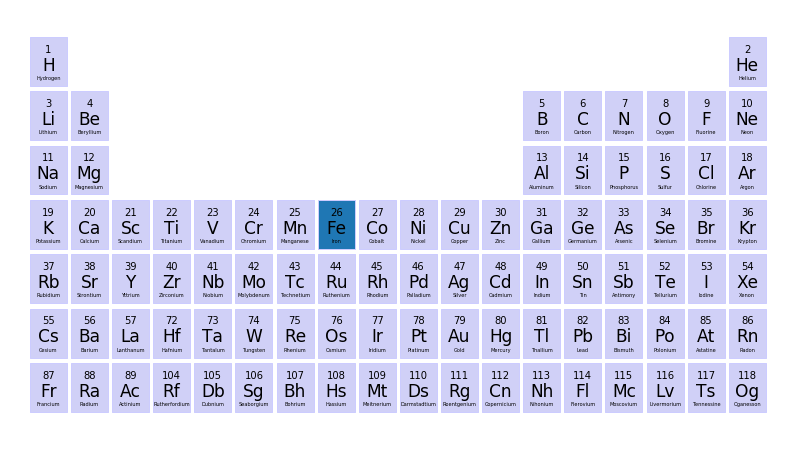

In [ ]:
ptable_plot(['Fe'])

## Creating the Moseley plot 

In order to develop a further intuition of XRF physics beyond Moseley's law, it is instructive to create a plot with simulations of theoretical pure element XRF spectra for the complete periodic system. 


I am not an expert in XRF physics. And therefore I am not able to calculate or look up the complex spectral patterns by myself. However, thanks to the open source scientific community advanced python packages are readily available from the python package index to simulate spectra. An authoritative resource for simulating XRF physics is `fisx`, the periodic table can be consulted using `mendeleev`, plotting and peak finding can be done with `scipy` and `matplotlib`. 
 

In [ ]:
my_elements = ['Ca', 'Cl', 'S', 'Fe']

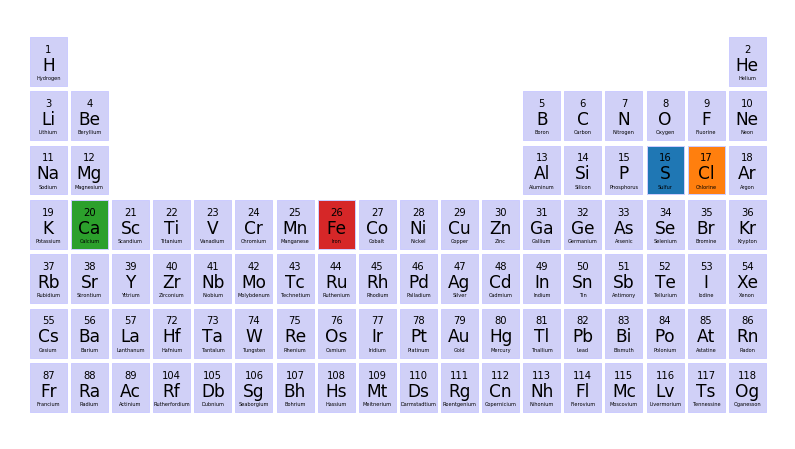

In [ ]:
ptable_plot(my_elements)

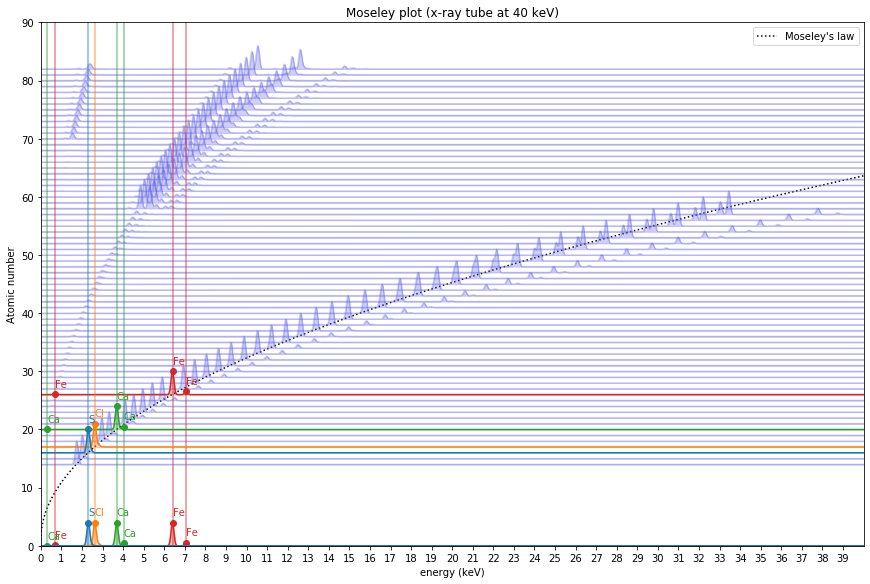

In [ ]:
fig = moseley_plot(tube_keV=40, elem_select=my_elements)